## Welcome to the tutorial on  Explainable Deep Learning. 

As a desclaimer, plese note that this tutorial is NOT FINAL !! This is pilot project that was done in just under two weeks. Team members have worked with each other on some of the methods, however, the different parts still need to be harmonized (library usage, data usage ...). 

The tutorial still needs to be made into a fully fledge teachable material (custom-made figures, text, questions that the presentator could ask, possible answers to this questions, references for the participants...). 

Also, this far exceeds an hour of presentation, we also need to choose which kind of things are teachable under an hour and which kinds of things are not. 


### Please know that : 

The majority of the team is commited to work throughout the year and make this into the teachable material that it deserves to be. If you are interesting in running this at EEML next year, we would be happy to make a more polished version that is easy to teach and catches the eye of the participants.

### Major TODOs : 

We need to fix two major things : 
Fix a new tutorial part called "TreeExplainer" which allows us to analyse trees (and random forrest). With an added interesting idea : explain a DL model using a tree/random forrest

We need to make sure the Boston dataset can be downloaded from anywhere

We need to implement CAM into this notebook in order to have it work on the cloud. 

We need to make sure that Shap works on any machine

In [ ]:
import torch 
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import optim 
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

While training a model, we typically want to pass samples in “minibatches” (batch_size = 100), reshuffle the data at every epoch to reduce model overfitting (shuffle = True), and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

At the heart of PyTorch data loading utility is the **torch.utils.data.DataLoader** class. It represents **a Python iterable over a dataset**

The snippet below has visualisation purposes (to get a good grasp of how our data actually looks like)



Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


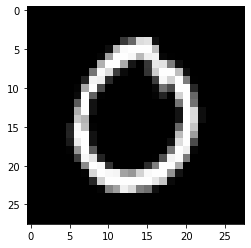

Label: 0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,

In [ ]:
Data_train = torch.utils.data.DataLoader(mnist_trainset, 
                                          batch_size=100, 
                                          shuffle=True,
                                          num_workers=1)
# We have loaded our MNIST dataset into the Dataloader object and can iterate through the dataset as needed
print(Data_train)

train_features, train_labels = next(iter(Data_train))
#iter() calls the __iter__() method on the Data_train which returns an iterator
#next() then calls the __next__() method on that iterator to get the first iteration. Running next() again will get the second item of the iterator, etc
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
#torch.squeeze(input, dim=None, *, out=None) -> Returns a tensor with all the dimensions of input of size 1 removed.
# For example, if input is of shape:(A×1×B×C×1×D) then the out tensor will be of shape: (A×B×C×D).
label = train_labels[0]
plt.imshow(img, cmap = 'gray')
plt.show()
print(f'Label: {label}')
print(train_features)
print(train_labels)

**Don't get confused!!**

Our dataset is divided in smaller compartments called *batches*.

The number of *epochs* is the number of times the whole dataset is passed forward and backward through the neural network at once. Since this would require big computational costs, we need to divide the data in batches of smaller sizes and feed our model with them one by one.


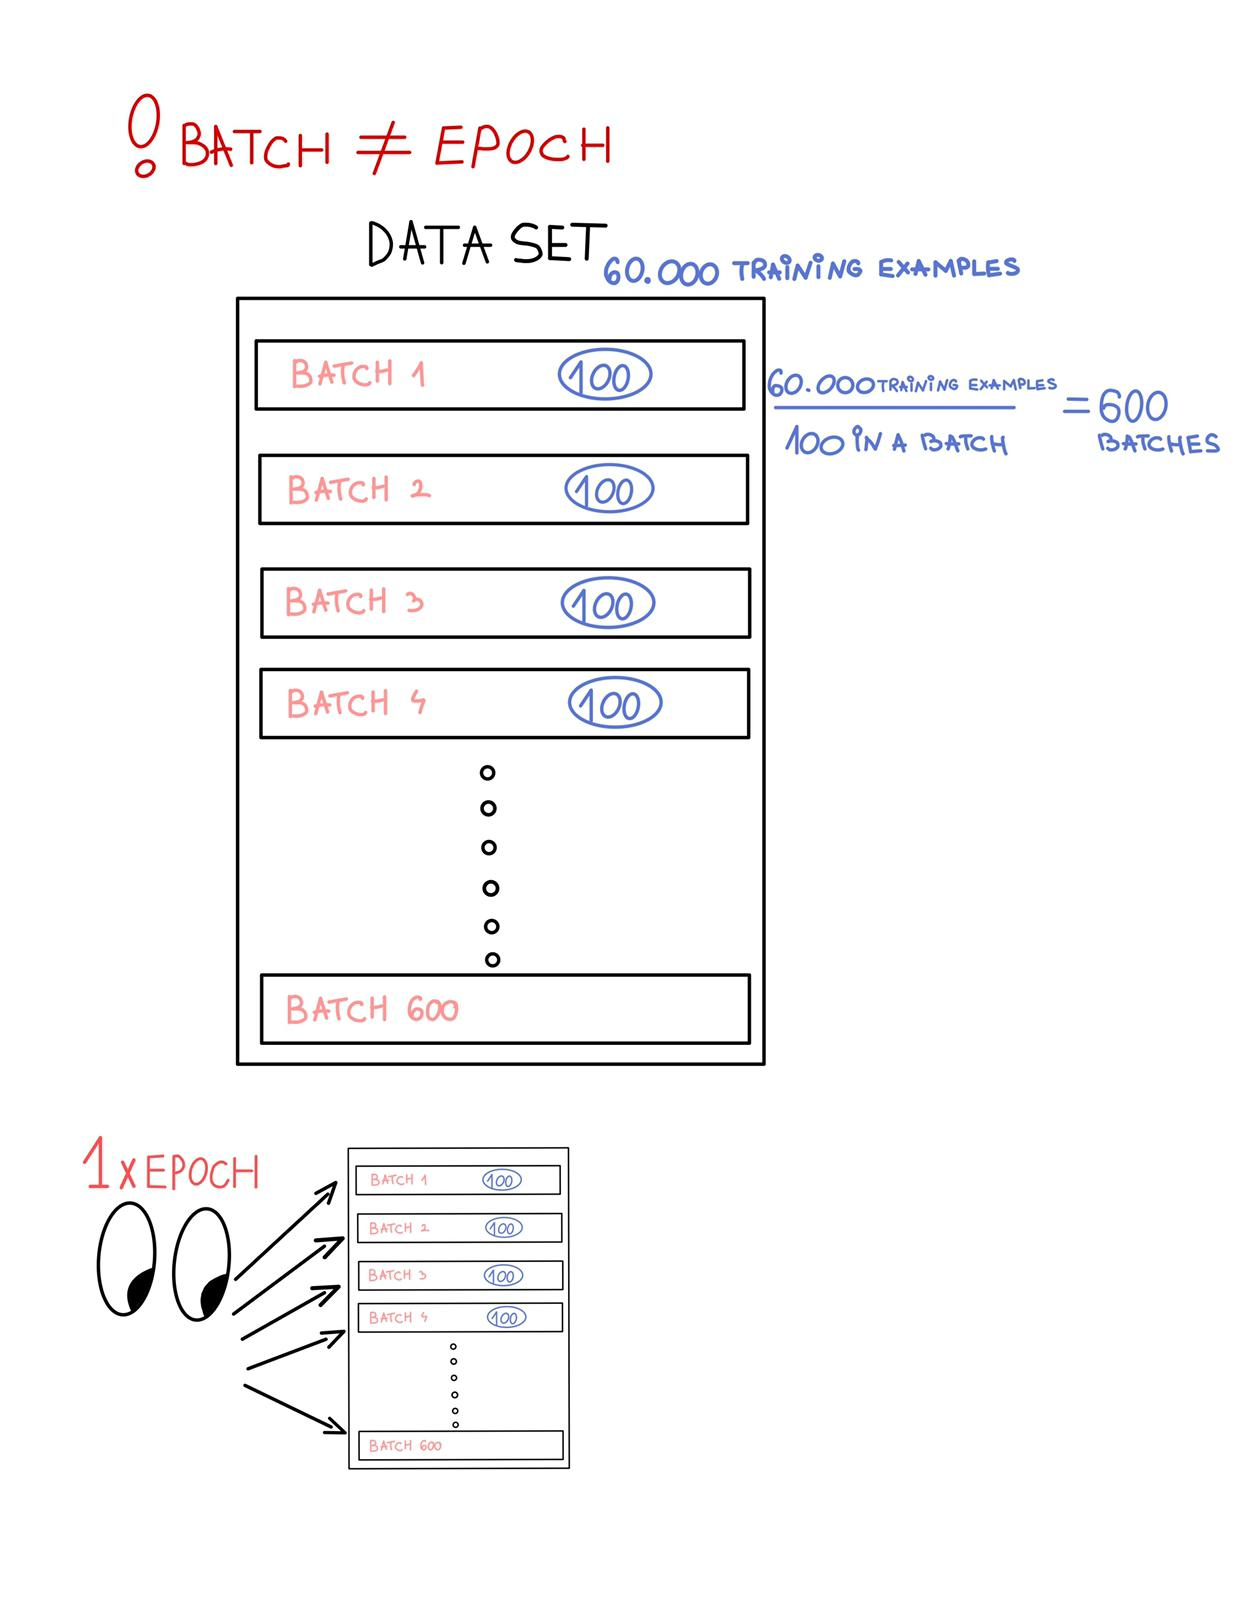

We'll use Cross-Entropy as our loss function. Cross-entropy builds upon the idea of entropy from information theory and calculates the number of bits required to represent or transmit an average event from one distribution compared to another distribution.

Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.


 For further details see 
1.   https://machinelearningmastery.com/cross-entropy-for-machine-learning/

2.   https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/



## set next cells as "code" to visualize batches

Label of this image: 1


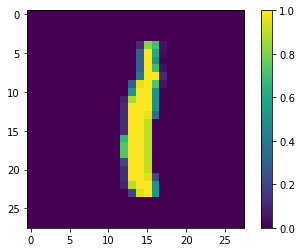

In [ ]:
print(f'Label of this image: {first[1][0].item()}')
#first[0][0] is the first image from the first batch
first[0][0].shape
first_ndarray = first[0][0].squeeze().numpy()
# numpy() function is the converter form torch.Tensor to numpy array.
plt.imshow(first_ndarray)
plt.colorbar()

### Model definition: 

We are going to use a simple CNN in order to make our predictions on the MNIST dataset


# <span style="color:red"> ADD REPRESENTATION OF THE SIMPLE CNN HERE </span>

This simple CNN will help us with model interpretation as it is easy to understand



In [ ]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, (5, 5), bias=True)
        self.flatt = nn.Flatten()
        self.dense1 = nn.Linear(576, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.flatt(x)
        x1 = self.dense1(x)
        return(F.softmax(x1, dim=1))
        

In [ ]:
# We now instantiate an object (net) of the CnnModel class, net being our architecture 
net = CnnModel()

In [ ]:
optimizer = optim.Adam(net.parameters(), lr = 0.01) 
loss_func = nn.CrossEntropyLoss()  
num_epochs = 10
total_step = len(Data_train) 
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(Data_train):
        b_x = Variable(images)   # images
        b_y = Variable(labels)   # labels
        output = net(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()  
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


Epoch [1/10], Step [100/600], Loss: 1.5846
Epoch [1/10], Step [200/600], Loss: 1.7129
Epoch [1/10], Step [300/600], Loss: 1.6053
Epoch [1/10], Step [400/600], Loss: 1.7136
Epoch [1/10], Step [500/600], Loss: 1.6073
Epoch [1/10], Step [600/600], Loss: 1.6475
Epoch [2/10], Step [100/600], Loss: 1.5605
Epoch [2/10], Step [200/600], Loss: 1.5825
Epoch [2/10], Step [300/600], Loss: 1.5939
Epoch [2/10], Step [400/600], Loss: 1.5416
Epoch [2/10], Step [500/600], Loss: 1.5935
Epoch [2/10], Step [600/600], Loss: 1.5791
Epoch [3/10], Step [100/600], Loss: 1.5589
Epoch [3/10], Step [200/600], Loss: 1.5089
Epoch [3/10], Step [300/600], Loss: 1.5568
Epoch [3/10], Step [400/600], Loss: 1.5830
Epoch [3/10], Step [500/600], Loss: 1.5575
Epoch [3/10], Step [600/600], Loss: 1.5374
Epoch [4/10], Step [100/600], Loss: 1.5898
Epoch [4/10], Step [200/600], Loss: 1.5711
Epoch [4/10], Step [300/600], Loss: 1.5404
Epoch [4/10], Step [400/600], Loss: 1.5403
Epoch [4/10], Step [500/600], Loss: 1.5209
Epoch [4/10

In [ ]:
Data_test = torch.utils.data.DataLoader(mnist_testset, 
                                          batch_size=100, 
                                          shuffle=True,
                                          num_workers=1)

In [ ]:
# Let's begin our testing loop. 

net.eval()
test_loss = 0
correct = 0
test_losses = []
with torch.no_grad():
    for images, labels in Data_test:
        output = net(images)
        test_loss += loss_func(output, labels).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        test_loss /= len(Data_test.dataset)
        test_losses.append(test_loss)

print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, 
        len(Data_test.dataset),100. * correct / len(Data_test.dataset)))


Test set: Avg. loss: 0.0002, Accuracy: 9229/10000 (92%)



# Analysing the model by looking at the weights



# <span style="color:red"> ADDING PRESENTATION WITH IMAGES AND TEXT ABOUT RETAINING MODEL WEIGHTS AND THE WAY CONVOLUTION WORKS </span>


In [ ]:
# define the input
input1 = first[0][1].reshape(1, 1, 28, 28) # Change the second value to change the example

In [ ]:
conv = net.conv1.weight.reshape(5,5).detach().numpy() # Let's fetch the convolution filter learned by the model

Text(0.5, 1.0, '5x5 Convolution filter learned by the model')

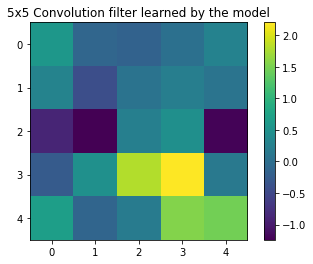

In [ ]:
plt.imshow(conv) # Let's plot 
plt.colorbar()
plt.title("5x5 Convolution filter learned by the model")

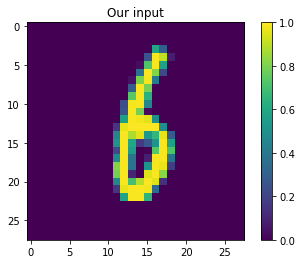

In [ ]:

#first[0][0] is the first image from the first batch
first[0][1].shape # Change the second value to change the example
first_ndarray = first[0][1].squeeze().numpy()
# numpy() function is the converter form torch.Tensor to numpy array.
plt.title("Our input")
plt.imshow(first_ndarray)
plt.colorbar()

In [ ]:
# Here we retrieve the output of the convolution layer from the input 
out_conv = net.conv1(input1).reshape(24,24).detach().numpy()

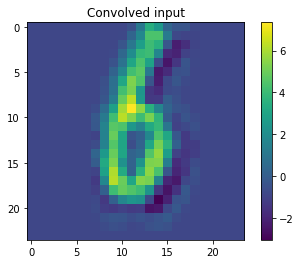

In [ ]:
plt.title("Convolved input")
plt.imshow(out_conv)
plt.colorbar()

## Questions to participants : 

What is the effect of convolution in your opinion ? How could that help ? 

(Answer -> improve contrast, more distinctions between borders = better prediction)

# <span style="color:red"> ADDING IMAGE SHOWING HOW THE WEIGHTS ARE DISTRIBUTED RELATING TO CLASS </span>

In [ ]:
# Here we retrieve the weights of the Dense layer (related to the right class)
right_class = first[1][1].item() # Change the second value to change the example
w = net.dense1.weight[right_class].reshape(24,24).detach().numpy()

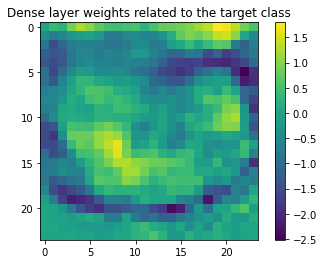

In [ ]:
plt.title("Dense layer weights related to the target class")
plt.imshow(w)
plt.colorbar()

## Question to participants : 

Do you see that the model is learning the right thing ? (i.e : does this look like the right class?)

(Answer -> depends on example, don't hesitate to let participants try other examples) 

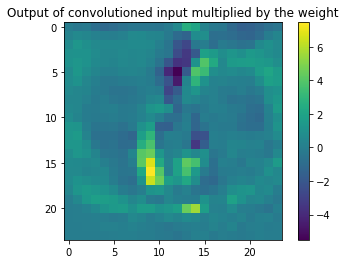

In [ ]:
plt.title("Output of convolutioned input multiplied by the weight")
plt.imshow((out_conv*w))
plt.colorbar()

# **Integrated Gradients** : simple, yet powerful explainability method

*What is it?*

Integrated Gradients is an axiomatic model interpretability algorithm that assigns an importance score to each input feature by approximating the integral of gradients of the model’s output with respect to the inputs along the path (straight line) from given baselines / references to inputs.

source: https://captum.ai/api/integrated_gradients.html


The integral of integrated gradients can be efficiently approximated via a summation. We simply sum the gradients at points occurring at
sufficiently small intervals along the straightline path from
the baseline x' to the input x.

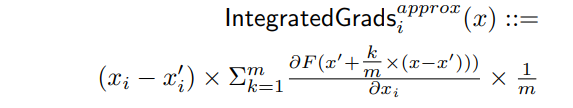

https://arxiv.org/pdf/1703.01365.pdf


*Why is Integrated Gradients superior to other interpretability techniques?*

-> it satisfies the two axioms **(Sensitivity and Implementation Invariance)**  that every attribution method must satisfy, but most known methods don't

-> it requires no modification to the original network

-> extraordinarily simple to implement

-> can be used to debug networks, extract rules from a network and enable the users of the network to engage beter with the model


For an easy-to-follow introduction to this topic, please read https://towardsdatascience.com/understanding-deep-learning-models-with-integrated-gradients-24ddce643dbf




Now, we'll prepare the right environment for implementing the Integrated Gradients method, using **Captum**, an open source, extensible library for model interpretability built on PyTorch. 

https://captum.ai/docs/introduction.html

### Let's implement it using the *Captum* library

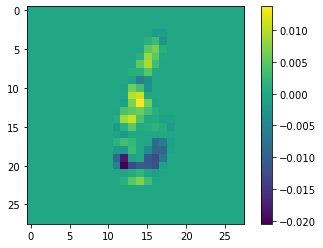

In [ ]:
import captum.attr as attr

input1.require_grad = True
baseline = torch.zeros(tuple(input1.size()))

# create an instance of my Integrated Gradients algorithm by passing the forward function of our model (net)
ig = attr.IntegratedGradients(net)

# to compute the attributions we are calling the attribute method on the ig object that we have created above
# by passing the input and a target index we would like to attribute to
attributions = ig.attribute(input1, target = 8)
new_attributions = attributions.reshape(tuple(input1.squeeze().size()))
plt.imshow(new_attributions)
plt.colorbar()


# <span style="color:red"> ADD MORE INFORMATION ABOUT ATTRIBUTIONS </span>

## Question to participants : 

How do integrated gradients compare with looking at the weights ? What are the similarities ? The differences ? Can you explain them ? 

Answer -> integrated gradients looks at differences from a baseline, looks only at one example (doesn't generalize), takes into account bias (not only weights) which our weights analysis method doesn't do.

However I.G. generalizes to more complicated models, weights analysis doesn't. 

# Deconvolution and occlusion analysis

In this part, we look at two methods that are a bit old but often pop up in tutorials on deep learning or in papers.

In summary, we could say that these aim to provide explanation for a *given input image*. We will shortly see that these methods are rather for illustration purposes than rigorous explanition.

**DISCLAIMER:** the notebook reflects the understanding of the author, so watch out for mistakes

## CNN implementation & training

In this tutorial, we will work with a simple CNN trained on two classes of MNIST.

Below, we only implement the standard pipeline. In lack of time, one can skip most of this, since we'll only need the trained model for further investigations.

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import numpy as np

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=lambda x: np.array(x))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=lambda x: np.array(x))

In [ ]:

from torch.utils.data import DataLoader, Subset

In [ ]:
def retrieve_indices(classes,dataset):
  class_indices=[i for i,label in enumerate(dataset.targets) if int(label) in classes] # label itself was a tensor :/
  return class_indices

In [ ]:

classes=[1,8]

In [ ]:
trainset=Subset(mnist_trainset,retrieve_indices(classes,mnist_trainset))

In [ ]:
testset=Subset(mnist_testset,retrieve_indices(classes,mnist_testset))

In [ ]:
train_dataloader=DataLoader(trainset,batch_size=50,shuffle=True)

In [ ]:
test_dataloader=DataLoader(testset,batch_size=50,shuffle=True)

In [ ]:
class mnist_cnn(nn.Module):

  def __init__(self,batch_transform,loss):
    super(mnist_cnn,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=4,stride=2)
    self.conv2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3,stride=2)
    self.conv3=nn.Conv2d(in_channels=20,out_channels=10,kernel_size=2,stride=2)
    self.dense=nn.Linear(in_features=90,out_features=1)
    self.batch_transform=batch_transform
    self.loss=loss

  def forward(self,x):

    x=self.batch_transform(x) # eg. rescale
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=torch.flatten(x,start_dim=1)
    x=torch.sigmoid(self.dense(x))

    return x

In [ ]:
def binarize_labels(labels,classes): # classes[0] becomes ~0, classes[1] ~1

  return ((labels-classes[0])/(classes[1]-classes[0])).to(torch.float32)

In [ ]:
def trainstep(model,optimizer,batch):

  labels=binarize_labels(batch[1],classes)

  optimizer.zero_grad()
  logits=model(batch[0])[:,0]

  loss=model.loss(logits,labels)

  loss.backward()
  optimizer.step()

  return loss.detach()



In [ ]:
model=mnist_cnn(batch_transform=lambda x: (x/255.).reshape(-1,1,28,28), loss=nn.BCELoss()) # standard choice to rescale image

In [ ]:
def accuracy(model,batch):

  n=batch[0].shape[0]

  probabilities=model(batch[0])[:,0]

  correct=0

  for i in range(n):
    if probabilities[i]>0.5 and batch[1][i]>4:
      correct+=1
    elif probabilities[i]<0.5 and batch[1][i]<4:
      correct+=1
  return correct/n


In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
for i in range(10):
  full_loss=0
  full_accuracy=0
  for j,batch in enumerate(train_dataloader):
    loss=trainstep(model,optimizer,batch)
    full_loss=full_loss*j/(j+1)+loss.detach()/(j+1) # compute average in a 'sliding' manner, maybe familiar from RL
    full_accuracy=full_accuracy*j/(j+1)+accuracy(model,batch)/(j+1)
  print('epoch completed')
  print(full_loss)
  print(full_accuracy)



epoch completed
tensor(0.6506)
0.5795108896271687
epoch completed
tensor(0.3328)
0.9428848283499455
epoch completed
tensor(0.1521)
0.9545108896271682
epoch completed
tensor(0.1145)
0.9611775562938358
epoch completed
tensor(0.0987)
0.9672886674049466
epoch completed
tensor(0.0880)
0.9702251753414545
epoch completed
tensor(0.0801)
0.9719841269841278
epoch completed
tensor(0.0738)
0.9746566998892582
epoch completed
tensor(0.0686)
0.9764691768180132
epoch completed
tensor(0.0643)
0.977606127722406


## Occlusion analysis

The idea is to mask out a part of the image and see how class probabilities vary. Idea is taken from https://arxiv.org/abs/1311.2901v2 by Zeiler and Fergus

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def mask_to_background(image,mask_size,top_left_anchor):

  # background of characters is 0

  x_a,y_a=top_left_anchor # expected as a tuple of 2

  if x_a+mask_size<=image.shape[0] and y_a+mask_size<=image.shape[1]:

    mask=torch.ones(image.shape,dtype=torch.float32)
    mask[x_a:x_a+mask_size,y_a:y_a+mask_size].multiply_(0)

    return image*mask
  else:
    print('invalid parameter combination')


Let us consider dividing the picture into a 7-by-7 grid (mask size 4) and occluding one square one time.

In [ ]:
image=next(iter(test_dataloader))[0][0]

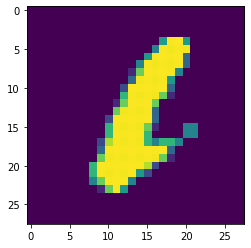

In [ ]:
plt.imshow(image)

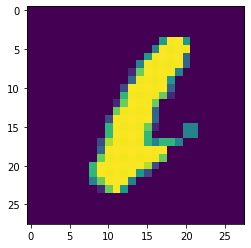

In [ ]:
plt.imshow(mask_to_background(image,mask_size=4,top_left_anchor=(18,18)))

In [ ]:
occlusion_map=torch.zeros(image.shape,dtype=torch.float32) # store results here

In [ ]:
m=4

for x_a in range(7):
  for y_a in range(7):
    masked_image=mask_to_background(image,mask_size=m,top_left_anchor=(x_a*m,y_a*m))
    prob=model(masked_image.reshape(1,28,28))
    occlusion_map[x_a*m:x_a*m+m,y_a*m:y_a*m+m]=prob # store results that spatially correspond to original image

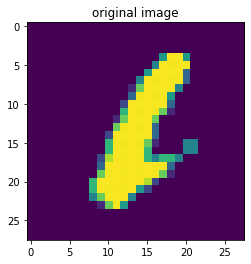

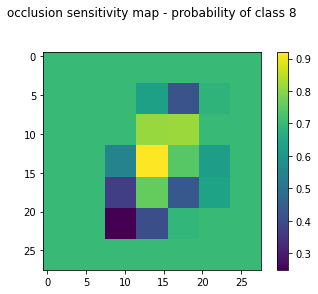

In [ ]:
plt.figure()
plt.imshow(image)
plt.title('original image')
plt.show()

plt.figure()
plt.imshow(occlusion_map.detach().numpy())
plt.title('occlusion sensitivity map - probability of class 8\n\n')
plt.colorbar()
plt.show()

## Deconvolutions



 ### intro

 We'll more or less follow: https://arxiv.org/abs/1311.2901v2 by Zeiler and Fergus whose paper promises to *'reveals the input stimuli that excite individual feature maps at any layer in the model'*. For some impressive figures, one shall refer to the paper but in summary, we can say that the real meaning of the outputs of the explanatory model is more or less unclear. It is also a question however, if it is meaningful to analyze single neuronal activations.

The purpose of this part in the tutorial is to give an insight into what is behind the omnipresent 'let us visualize what triggers single neurons' figures in intros to deep learning. Thus, the interested reader is advised to read through the rather lengthly theory part of the text too.

If you are skeptical about all of this (well, maybe you should be...) then just skim through the rest without taking it too seriously.

Either way, I highly recommend to look into paper [Towards falsifiable interpretability research](https://arxiv.org/abs/1311.2901v2) for a more recent, critical view on interpretability methods for DNNs with interesting takeaways for methods like this.

### the method

The method is best summarized in the words of the authors:

*'To examine a convnet, a deconvnet is attached to each
of its layers, as illustrated in Fig. 1(top), providing a
continuous path back to image pixels. To start, an
input image is presented to the convnet and features
computed throughout the layers. To examine a given
convnet activation, we set all other activations in the
layer to zero and pass the feature maps as input to
the attached deconvnet layer. Then we successively
(i) unpool, (ii) rectify and (iii) filter to reconstruct
the activity in the layer beneath that gave rise to the
chosen activation. This is then repeated until input
pixel space is reached.'*


*'Unpooling: In the convnet, the max pooling operation is non-invertible, however we can obtain an approximate inverse by...'* (we won't need this in the tutorial)

*'Rectification: The convnet uses relu non-linearities,
which rectify the feature maps thus ensuring the feature maps are always positive. To obtain valid feature reconstructions at each layer (which also should
be positive), we pass the reconstructed signal through
a relu non-linearity.'*

*'Filtering: The convnet uses learned filters to con-
volve the feature maps from the previous layer. To
invert this, the deconvnet uses transposed versions of
the same filters, but applied to the rectified maps, not
the output of the layer beneath. In practice this means
flipping each filter vertically and horizontally.'*



### OK but what does this mean?

Before jumping into code, let's familiarize ourselves with the way deconvolutional networks work. This seemingly simple goal is not so straightforward to achieve, since the original paper we follow and the Pytorch documentation do not seem to refer to the same thing.

In the **paper**, it is said that '*we successively
(i) unpool, (ii) rectify and (iii) filter to reconstruct
the activity in the layer beneath that gave rise to the
chosen activation...*' In other words, the process of deconvolution is seen as some kind of inversion.

We hope to achieve 'filtering' with the transposed convolution layer of **Pytorch**, where the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) reads as: *'This module can be seen as the gradient of Conv2d with respect to its input. It is also known as a fractionally-strided convolution or a deconvolution (although it is not an actual deconvolution operation)'*

Nice.

To make sense of all of this, we refer to yet another resource that approaches from theory-side: https://link.springer.com/chapter/10.1007/978-3-319-46466-4_8

Based on that, we can say the following:

Suppose that we have a (scalar) feature p that is dependent on the output of a convolutional layer and we know the gradient of p with respect to the output.

 First we aim to compute the gradient of p with respect to the *input* of the layer. Conceptually, it is very simple, since the convolution operation is basically $\mathbf{y}=A \mathbf{x}+\mathbf{b}$ where matrix A does the convolution (with a nontrivial structure) and both **x** input and **y** output are represented as vectors.

 The desired output is: $ (\frac{\partial p}{\partial \mathbf{x}})_i = \frac{\partial p}{\partial x_i}= \sum_j \frac{\partial p}{\partial y_j} \frac{\partial y_j}{\partial x_i} = \sum_j   \frac{\partial p}{\partial y_j} A_{ji} = ( A^T  \frac{\partial p}{\partial \mathbf{y}})_i$

 Now we can see that the paper and docs are basically the same for 'filtering' but it is unclear in what sense this operation will contribute to *' reconstruct the activity in the layer beneath that gave rise to the chosen activation'*

Moreover, the use of ReLU needs to be thought over. The paper proposes that ReLU is applied before passing features through the transposed convlayers. The reader is reminded that this choice is (i) not straightforward (ii) not the only choice. Different ways to 'reverse' ReLU and it leads to significatly different outcomes according to the cited Springer chapter. Also, this particular choice makes the interpretation of the outputs of a deconvolutional net hardly interpretable, since this is *not* the gradient of p wrt. the input pixels. (Note that other choices with ReLU lead to a well defined meaning of the output, see SaliNets for network saliency.)

In practice, we mask out all but one activation in a custom layer and then pass through deconvolutions. It is not hard to realize that in this case, p is the (chosen activation) times (the output of the chosen neuron). It also makes clear that there is not much point in passing a whole activation block through the deconv architecture.





Now then let's get down to coding finally:

In [ ]:
image=next(iter(train_dataloader))[0][0]

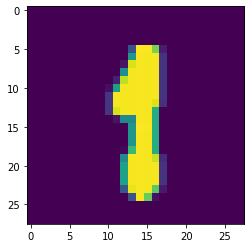

In [ ]:
plt.imshow(image)

In [ ]:
# compute activation maps
activations=[]
x=image.reshape(1,28,28)
x=model.batch_transform(x)
for layer in [model.conv1,model.conv2,model.conv3]:
  x=F.relu(layer(x))
  activations.append(x)

In [ ]:
def mask(x,y,d,size): # make a mask for picking a given neuronal activation
  mask=torch.zeros(size,dtype=torch.float32)
  mask[:,d,x,y]=1.

  return mask

One could go in a less pedestrian way for the deconvnet, but since our net is lightweight, there is no point in it. We will re-use the weights from the trained convlayers as suggested in the paper. The only question is if we need to flip the kernels. Let's try first without that!

In [ ]:
# we'll use the hyperparameters from the original net
# set bias to zero: it is not meaningful to use them when doing deconvolution

deconv1=nn.ConvTranspose2d(in_channels=10,out_channels=1,kernel_size=4,stride=2)
deconv1.weight=nn.Parameter(model.conv1.weight)
deconv1.bias=None

deconv2=nn.ConvTranspose2d(in_channels=20,out_channels=10,kernel_size=3,stride=2)
deconv2.weight=nn.Parameter(model.conv2.weight)
deconv2.bias=None

deconv3=nn.ConvTranspose2d(in_channels=10,out_channels=20,kernel_size=2,stride=2)
deconv3.weight=nn.Parameter(model.conv3.weight)
deconv3.bias=None


In [ ]:
def deconv_from_layer_list(input,layers): # implementing the method from the paper
  x=input
  for layer in layers:
    x=layer(F.relu(x))
  return x

In [ ]:
activation=activations[0]*mask(1,1,1,activations[0].shape) # pick one from the first activation block's second kernel at position 1,1

In [ ]:
out=deconv_from_layer_list(activation,[deconv1]) # deconvolve - what do you expect go get?

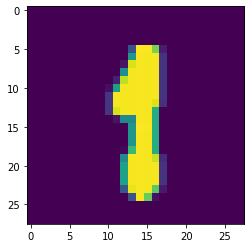

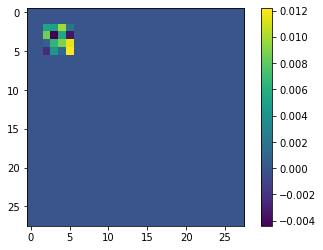

In [ ]:
out_=out.detach().numpy()

plt.figure()
plt.imshow(image[:,:])
plt.figure()
plt.imshow(out_[0,0,:,:])
plt.colorbar()

Yup, it looks like a convolutional kernel! When thinking about it, it is obvious that this is what we shall get. Now the proof is in the pudding:

In [ ]:
activation[0,1,1,1] # we picked this feature and set everything else to 0

tensor(0.0360, grad_fn=<SelectBackward>)

In [ ]:
out_[0,0,2:6,2:6] # the colorful (nonzero) area above

array([[ 0.00520977,  0.00502858,  0.0097415 ,  0.00203995],
       [ 0.00857142, -0.00438249,  0.00545969, -0.00351863],
       [ 0.00070669,  0.00642894,  0.00890993,  0.0115265 ],
       [-0.00227779,  0.00435792,  0.00123284,  0.01216294]],
      dtype=float32)

In [ ]:
model.conv1.weight[1,0,:,:] # weight from model corresponding to the same filter we want to deconvolve

tensor([[ 0.1449,  0.1399,  0.2709,  0.0567],
        [ 0.2384, -0.1219,  0.1518, -0.0979],
        [ 0.0197,  0.1788,  0.2478,  0.3206],
        [-0.0633,  0.1212,  0.0343,  0.3383]], grad_fn=<SliceBackward>)

One can check that we got back our (conv kernel) times (activation) as expected so it was right not to flip weights when initializing transposed convlayers.

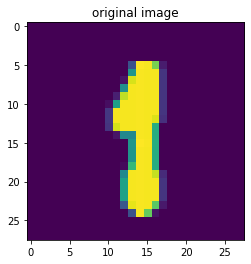

In [ ]:
plt.figure()
plt.title('original image')
plt.imshow(image)

In [ ]:
# for a more interesting example

outputs=[]

for kernel in range(10):
  for x_ in range(3):
    for y_ in range(3):
      text='reconstruction from kernel %d, x: %d, y: %d'%(kernel,x_,y_)

      activation=activations[2]*mask(x_,y_,kernel,activations[2].shape)
      out=deconv_from_layer_list(activation,[deconv3,deconv2,deconv1]) # behold the order of deconv layers

      out_=out.detach().numpy()
      fig=(out_[0,0,:,:])

      outputs.append((float(activation[0,kernel,x_,y_].detach()),text,fig))




In [ ]:
sorted_outputs=sorted(outputs,key=lambda x: -x[0])  # descending by activation

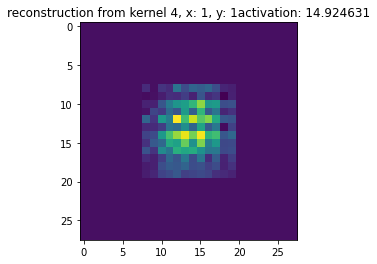

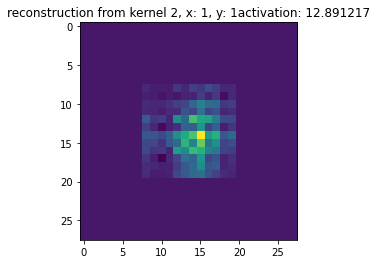

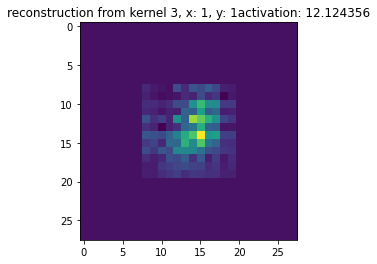

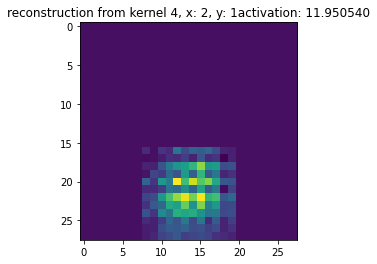

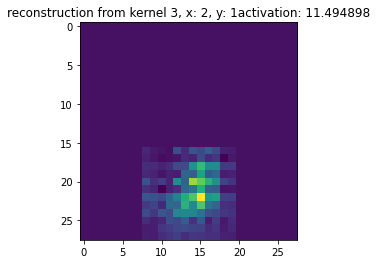

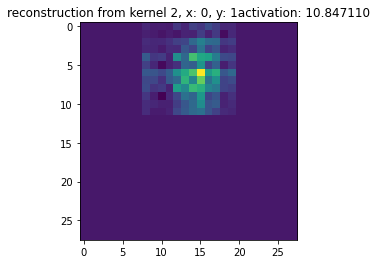

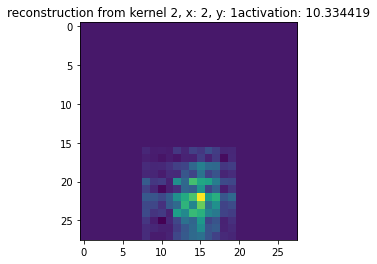

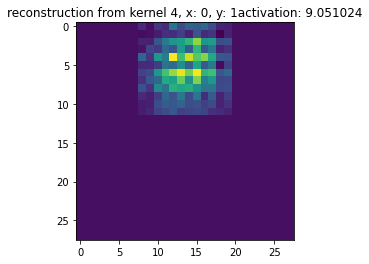

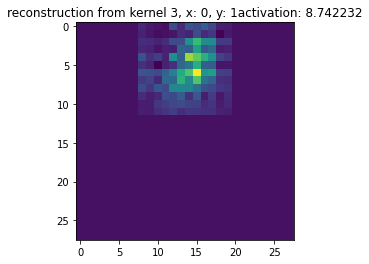

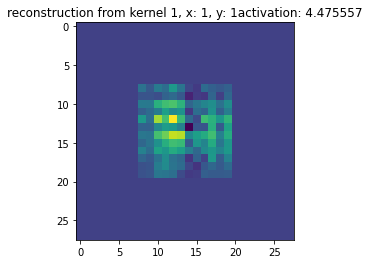

In [ ]:
for i in range(10): # top 10 outputs
  plt.figure()
  plt.title(sorted_outputs[i][1]+ 'activation: %f'%(sorted_outputs[i][0]))
  plt.imshow(sorted_outputs[i][2])
  plt.show()

Well, it is not very informative. Let's see for an 8!

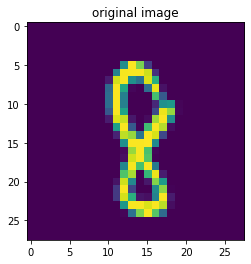

In [ ]:
image=next(iter(train_dataloader))[0][0]
plt.figure()
plt.title('original image')
plt.imshow(image)

In [ ]:
# compute activation maps
activations=[]
x=image.reshape(1,28,28)
x=model.batch_transform(x)
for layer in [model.conv1,model.conv2,model.conv3]:
  x=F.relu(layer(x))
  activations.append(x)

In [ ]:
# for a more interesting example

outputs=[]

for kernel in range(10):
  for x_ in range(3):
    for y_ in range(3):
      text='reconstruction from kernel %d, x: %d, y: %d'%(kernel,x_,y_)

      activation=activations[2]*mask(x_,y_,kernel,activations[2].shape)
      out=deconv_from_layer_list(activation,[deconv3,deconv2,deconv1]) # behold the order of deconv layers

      out_=out.detach().numpy()
      fig=(out_[0,0,:,:])

      outputs.append((float(activation[0,kernel,x_,y_].detach()),text,fig))

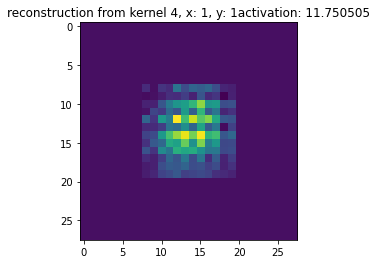

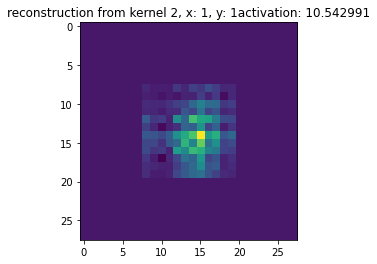

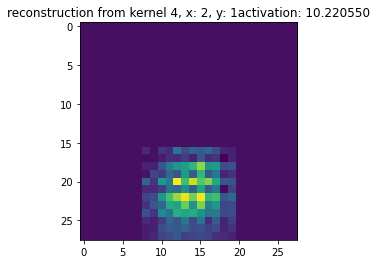

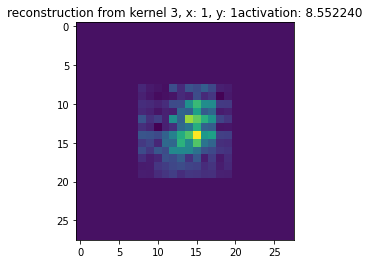

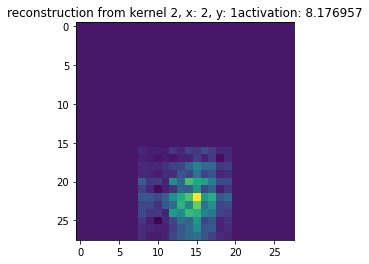

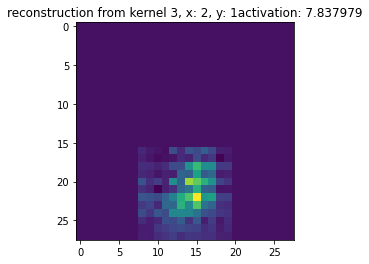

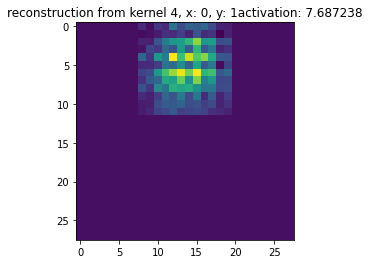

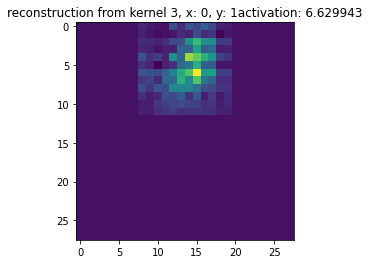

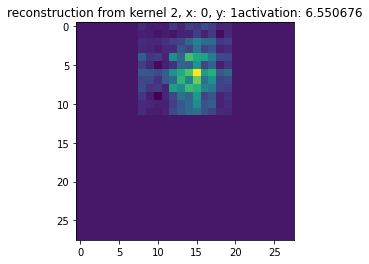

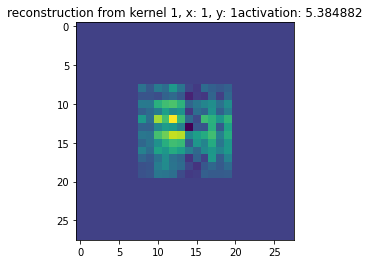

In [ ]:
sorted_outputs=sorted(outputs,key=lambda x: -x[0])  # descending by activation
for i in range(10): # top 10 outputs
  plt.figure()
  plt.title(sorted_outputs[i][1]+ 'activation: %f'%(sorted_outputs[i][0]))
  plt.imshow(sorted_outputs[i][2])
  plt.show()

Well, let's say that we can observe some horizontal lines that may be absent for 1s but present for 8s. Anyway, this demo is not very convincing but this is what we could to with such a simple architecture.

For fancy images, refer to the sources linked.




# ScoreCAM

## Introduction

Visual Explainability Methods  produce a saliency map showing how important each pixel is for their label of classification. These are suitable for image data because they are visual-appealing and can be generally classified into two types:

**a. Backpropagation-based Methods**
These methods distinguish the effect of input features on the final prediction based on
some evaluation of gradient signals passed from output to input during network training. Saliency maps highlight the pixels in order of importance to the DNN prediction, based on derivatives. Several works have followed line, some of these methods
are: Activation Maximization , Deconvolution, Class Activation Mapping
(CAM) and the subsequent methods Grad-CAM and GradCAM++ that
generalize it, Layer-Wise Relevance Propagation (LRP), Deep Learning Important
FeaTures (DeepLIFT), Integrated Gradients. These methods generally have low
quality and noise and lose information in the backpropagation process (vanishing gradient) due to Sigmoid and ReLU activations.

**b. Perturbation-based Methods**
These methods compare the difference in the prediction when the input features are
changed. The most known methods are Occlusion by different types of perturbations
such as replacing the region with a constant value, adding noise to a region, and blurring
a region; and Smooth Masks.

It is important to note that saliency-based methods have presented many disadvantages.
Saliency maps are based on only one image (Local Methods,.3). Thus, to draw
a conclusion for each class with these methods, the human will have to do it in a one-by-one
process. Also, saliency-based methods are not robust, since they are vulnerable to adversarial attacks as it was presented by Ghorbani[4]. Kindermans and Hooker[5] explored how some saliency methods behaved when the input data was shifted, e.g. change in the input encoding from [0; 1] to [−1; 0], addition of constant squares or a hand drawn cat image in the
background. Their results showed that explanations generated by methods such as Deconvolution, Integrated Gradients are different than the ones produced before these simple
transformations, which means that explanations can be manipulated and these methods are not
reliable.
Since evaluating the quality of an explanation only with visual inspection can be deceiving,
Adebayo et al.[2] proposed Sanity Checks, a new way to evaluate explanations based on the
fact that if the prediction changes, the explanation would also change. For this, they performed
two types of tests: the model parameter randomization test, and the data randomization test.
Model parameters encode what the DNN has learned, in order to debug the DNN and thus,
improve their performance, it is necessary that saliency methods be sensitive to model parameters.

Figure 1 shows the explanation for an age bone predictor trained on Inception v4 and
after randomizing all the weights in the model.

Figure 2 shows the performance of explainability methods based on saliency maps after applying a cascading randomization on Inception V3
trained with ImageNet. Notice that even though the weights on the network change (that is, the
prediction changed), the saliency map of some methods remains the same, while Gradient and
GradCAM passed the sanity checks.




![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/sanity-smooth.png?raw=true)

*Figure 1: Explanations B (trained Inception v4) and C (Inception v4 with Random weights) showing no difference. Figure reproduced from Adebayo et al.[2].*

![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/saliency.png?raw=true)

*Figure 2: Saliency results for diverse methods after Cascading Randomization on Inception
V3. They do not accomplish sanity check question: When prediction changes, do explanations
change? Figure reproduced from Adebayo et al.[2].*



Furthermore, saliency methods can obtain deceitful explanations. Fong et al. [3] showed
how different visual methods can get a different explanation without the need of changing the
input as it was discussed before. For example, in Figure 3, in the first row it can be seen in the firt
row the results for some Backpropagation-based Methods and Perturbation-based Methods for
the label “chocolate-sauce”, and how different the heatmaps are, some explanations highlighted
he chocolate pot or the spoon or both. These different explanations generate confusion about
what the network is really basing on for its decision. To prove what method was accurate, they
occluded some regions in the image and compared how the prediction of the DNN changed
(second row in Figure 3), demonstrating that the spoon was indeed what the DNN 3focused on.
This can be because of some bias in the dataset that is most of chocolate sauce images have a
spoon.


![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/falsifiabl.png?raw=true)
*Figure 3: Comparison of Explanations for the label “Chocolate sauce”. The first row shows
results from different visual methods. The second row shows how the prediction accuracy
changes after occluding a part (red box) of the image. This network classified the image as a
chocolate sauce with 0.61 of accuracy. When occluding the chocolate pot, the accuracy for this
label turns to be 0.351. However, if just the handle of the spoon is occluded, the accuracy for
the label ‘chocolate sauce’ drops to 0.015, even though the image still contains ins the chocolate
pot and the part of the spoon with chocolate. Figure reproduced from Fong et al.[3].*


Last year, on CVPR 2020, a combination of perturbation and Class Activation Mapping based methods was presented. Wang et al.[1] proposed a visual explanation method, Score-CAM,  giving a score to each activation map according to how each one will affect the prediction when applied as a mask to the input image. In this notebook we will show some basic experiments with this method.

The  published paper is available [here](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w1/Wang_Score-CAM_Score-Weighted_Visual_Explanations_for_Convolutional_Neural_Networks_CVPRW_2020_paper.pdf)  and official code is on [Github](https://github.com/haofanwang/Score-CAM)

## ScoreCAM Algorithm



1.   Extract  activation maps at the desired layer
2.   Upsample maps to the original input size in the network
3.   Normalize maps values  in the range of 0-1
4.   Apply the activation map as a mask to the input by multiplying the normalized activation map
5.   Feed masked inputs into CNN model and softmax
6.   Define weight as the score of target class
7.   Get final class discriminative localization map as linear weighted combination of all activation maps




## Simple Experiments

### CNN implementation & training

In this section, a classifier for classes 1 and 8 of MNIST is trained.

In [ ]:
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM

import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=lambda x: np.array(x))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=lambda x: np.array(x))


In [ ]:
from torch.utils.data import DataLoader, Subset
def retrieve_indices(classes,dataset):
  class_indices=[i for i,label in enumerate(dataset.targets) if int(label) in classes] # label itself was a tensor :/
  return class_indices

classes=[1,8]
trainset=Subset(mnist_trainset,retrieve_indices(classes,mnist_trainset))

testset=Subset(mnist_testset,retrieve_indices(classes,mnist_testset))

train_dataloader=DataLoader(trainset,batch_size=50,shuffle=True)

test_dataloader=DataLoader(testset,batch_size=50,shuffle=True)

In [ ]:

class mnist_cnn(nn.Module):

  def __init__(self,batch_transform,loss):
    super(mnist_cnn,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=4,stride=2)
    self.conv2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3,stride=2)
    self.conv3=nn.Conv2d(in_channels=20,out_channels=10,kernel_size=2,stride=2)
    self.dense=nn.Linear(in_features=90,out_features=1)
    self.batch_transform=batch_transform
    self.loss=loss

  def forward(self,x):

    x=self.batch_transform(x) # eg. rescale
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=torch.flatten(x,start_dim=1)
    x=torch.sigmoid(self.dense(x))

    return x

In [ ]:
def binarize_labels(labels,classes): # classes[0] becomes ~0, classes[1] ~1

  return ((labels-classes[0])/(classes[1]-classes[0])).to(torch.float32)


def trainstep(model,optimizer,batch):

  labels=binarize_labels(batch[1],classes)

  optimizer.zero_grad()
  logits=model(batch[0])[:,0]

  loss=model.loss(logits,labels)

  loss.backward()
  optimizer.step()

  return loss.detach()

In [ ]:
model=mnist_cnn(batch_transform=lambda x: (x/255.).reshape(-1,1,28,28), loss=nn.BCELoss()) # standard choice to rescale image
print(model)

mnist_cnn(
  (conv1): Conv2d(1, 10, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(20, 10, kernel_size=(2, 2), stride=(2, 2))
  (dense): Linear(in_features=90, out_features=1, bias=True)
  (loss): BCELoss()
)


In [ ]:

def accuracy(model,batch):

  n=batch[0].shape[0]

  probabilities=model(batch[0])[:,0]

  correct=0

  for i in range(n):
    if probabilities[i]>0.5 and batch[1][i]>4:
      correct+=1
    elif probabilities[i]<0.5 and batch[1][i]<4:
      correct+=1
  return correct/n

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [ ]:

for i in range(10):
  full_loss=0
  full_accuracy=0
  for j,batch in enumerate(train_dataloader):
    loss=trainstep(model,optimizer,batch)
    full_loss=full_loss*j/(j+1)+loss.detach()/(j+1) # compute average in a 'sliding' manner, maybe familiar from RL
    full_accuracy=full_accuracy*j/(j+1)+accuracy(model,batch)/(j+1)
  print('epoch completed')
  print(full_loss)
  print(full_accuracy)

epoch completed
tensor(0.6454)
0.8215485418973799
epoch completed
tensor(0.3431)
0.9463768918420086
epoch completed
tensor(0.1478)
0.9567737172388345
epoch completed
tensor(0.1067)
0.9633074935400516
epoch completed
tensor(0.0894)
0.9681358434846814
epoch completed
tensor(0.0782)
0.9718789221114802
epoch completed
tensor(0.0699)
0.9749206349206359
epoch completed
tensor(0.0639)
0.9773809523809524
epoch completed
tensor(0.0583)
0.978492063492064
epoch completed
tensor(0.0541)
0.9805426356589153


### Score-CAM

In [ ]:
# Code adapted from https://github.com/yiskw713/ScoreCAM
class ScoreCAM(CAM):
    """ Score CAM """

    def __init__(self, model, target_layer, n_batch=32):
        super().__init__(model, target_layer)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
        """
        self.n_batch = n_batch

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        with torch.no_grad():
            _, _, H, W = x.shape
            device = x.device

            self.model.zero_grad()
            score = self.model(x)
            prob = F.softmax(score, dim=1)

            if idx is None:
                p, idx = torch.max(prob, dim=1)
                idx = idx.item()
                #print("predicted class ids {}\t probability {}".format(idx, p))

            # 1. Getting activation maps
            self.activations = self.values.activations.to('cpu').clone()
            self.activations = F.relu(self.activations)
            # 2. Upsampling
            self.activations = F.interpolate(
                self.activations, (H, W), mode='bilinear')
            _, C, _, _ = self.activations.shape

            # 3. Normalization
            act_min, _ = self.activations.view(1, C, -1).min(dim=2)
            act_min = act_min.view(1, C, 1, 1)
            act_max, _ = self.activations.view(1, C, -1).max(dim=2)
            act_max = act_max.view(1, C, 1, 1)
            denominator = torch.where(
                (act_max - act_min) != 0., act_max - act_min, torch.tensor(1.)
            )

            self.activations = self.activations / denominator

           # 4. generate masked images and 5. calculate class probabilities
            probs = []
            for i in range(0, C, self.n_batch):
                mask = self.activations[:, i:i+self.n_batch].transpose(0, 1)
                mask = mask.to(device)
                masked_x = x * mask
                score = self.model(masked_x)
                probs.append(F.softmax(score, dim=1)[:, idx].to('cpu').data)

            # 6. Extracting weight as the score
            probs = torch.stack(probs)
            weights = probs.view(1, C, 1, 1)

            # 7. Linear weighted combination
            cam = (weights * self.activations).sum(1, keepdim=True)
            cam = F.relu(cam)
            cam -= torch.min(cam)
            cam /= torch.max(cam)

        return cam.data, idx

    def __call__(self, x):
        return self.forward(x)

To test ScoreCAM, last convolutional layer will be chosen.

In [ ]:
target_layer = model.conv3
wrapped_model = ScoreCAM(model, target_layer)

/Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


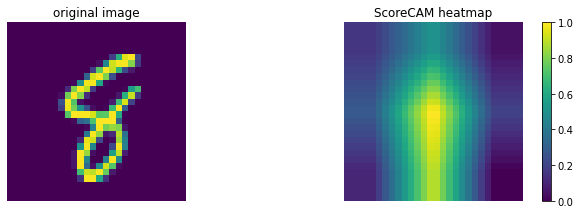

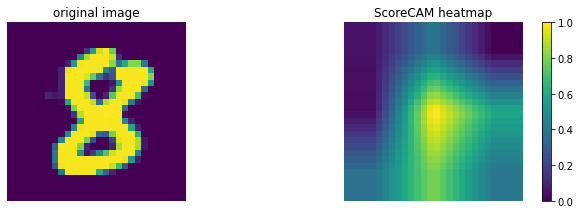

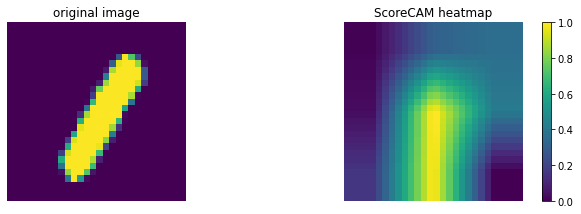

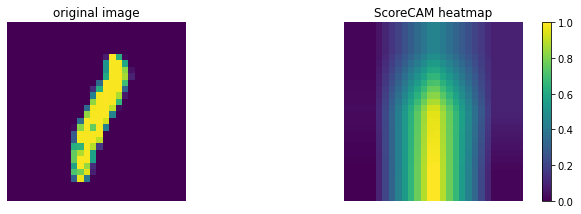

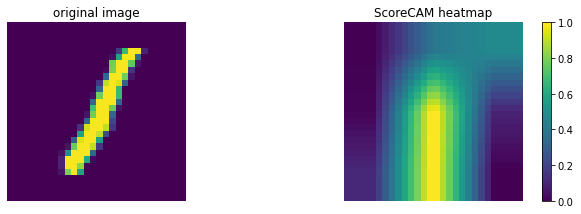

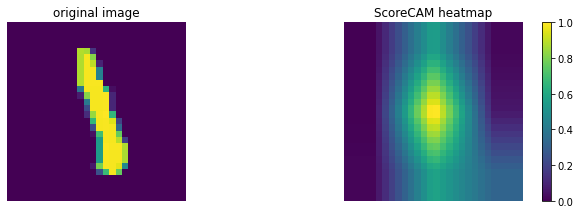

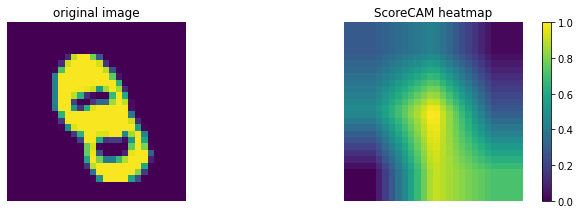

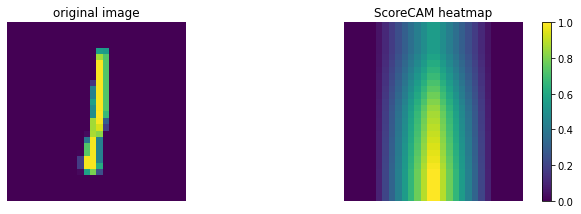

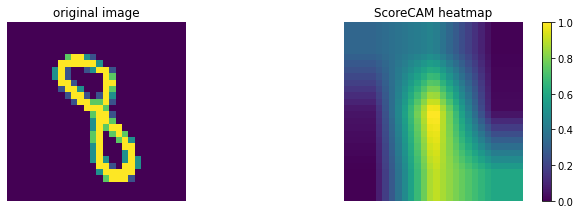

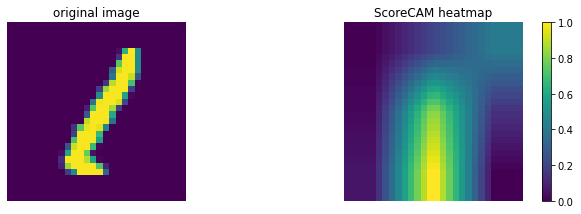

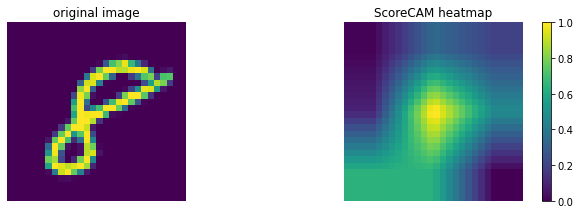

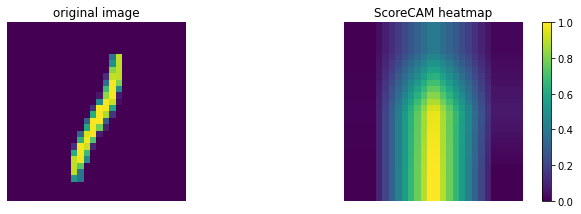

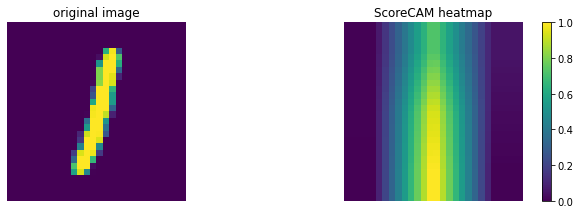

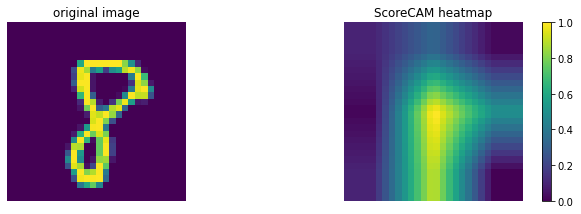

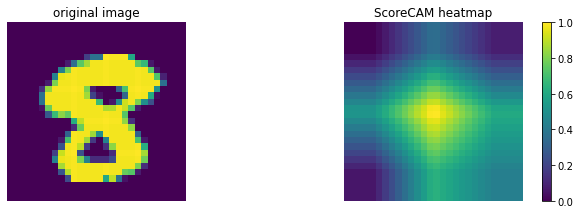

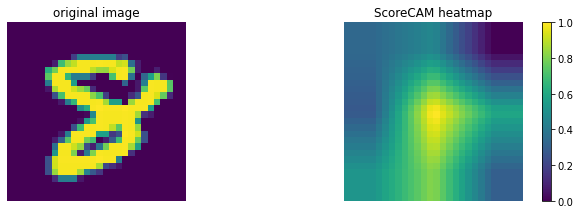

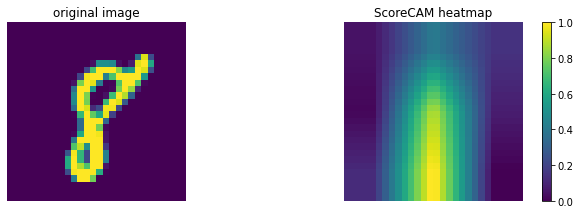

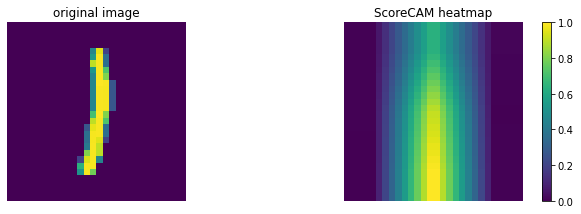

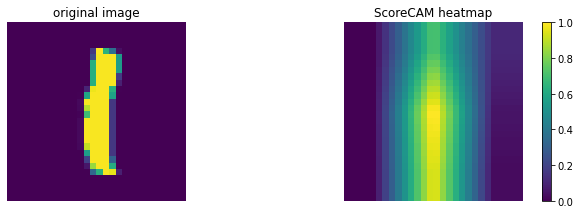

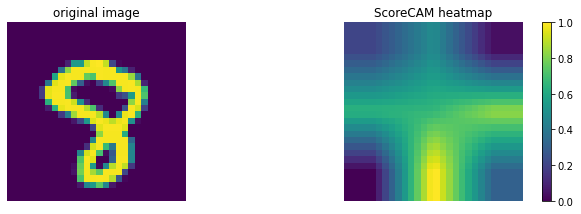

In [ ]:
for i in range(20):
    image=next(iter(test_dataloader))[0][0]
    cam, idx = wrapped_model(torch.reshape(image, (1,1,image.shape[0], image.shape[1])))
    fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
    axs[0].imshow(image)
    axs[0].set_title('original image')
    axs[0].axis('off')

    a=axs[1].imshow(cam.squeeze().numpy())
    axs[1].set_title('ScoreCAM heatmap')
    axs[1].axis('off')

    plt.tight_layout()
    plt.colorbar(a)
    plt.show()

# References
[1] H. Wang, Z. Wang, M. Du, F. Yang, Z. Zhang, S. Ding, P. Mardziel e X. Hu. Score-cam:
Score-weighted visual explanations for convolutional neural networks. In Proceedings of
the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops, pages
24–25, 2020.

[2] J. Adebayo, J. Gilmer, M. Muelly, I. Goodfellow, M. Hardt e B. Kim. Sanity checks for saliency maps. Advances in Neural Information Processing Systems, 2018-Decem(NIPS):
9505–9515, 2018. ISSN 10495258.

[3] R. C. Fong e A. Vedaldi. Interpretable explanations of black boxes by meaningful perturbation. In Proceedings of the IEEE International Conference on Computer Vision, pages
3429–3437, 2017.

[4] A. Ghorbani, A. Abid e J. Zou. Interpretation of neural networks is fragile. Proceedings
of the AAAI Conference on Artificial Intelligence, 33(01):3681–3688, Jul. 2019. doi: 10.
1609/aaai.v33i01.33013681. URL https://ojs.aaai.org/index.php/AAAI/article/view/4252.

[5] P.-J. Kindermans, S. Hooker, J. Adebayo, M. Alber, K. T. Schutt, S. D ¨ ahne, D. Erhan e ¨
B. Kim. The (Un)reliability of Saliency Methods, pages 267–280. Springer International
Publishing, Cham, 2019. ISBN 978-3-030-28954-6. doi: 10.1007/978-3-030-28954-6 URL https://doi.org/10.1007/978-3-030-28954-6_14


# Boston House Prices
## About the Dataset
We will be working on a data set that comes from the real estate industry in Boston (US). This database contains 14 attributes. The target variable refers to the median value of owner-occupied homes in 1000 USD's.

* CRIM: per capita crime rate by town
* ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS: proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: nitric oxides concentration (parts per 10 million)
* RM: average number of rooms per dwelling
* AGE: proportion of owner-occupied units built prior to 1940
* DIS: weighted distances to five Boston employment centres
* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per 10,000 USD
* PTRATIO: pupil-teacher ratio by town
* B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT: lower status of the population (%)
* MEDV: Median value of owner-occupied homes in 1000 USD's (Target)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'sklearn'

## Loading Data

In [ ]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT', 'PRICE']

# DATA Needs to be automatically downloadable ! 

In [ ]:
data = pd.read_csv("../data/housing.csv", delim_whitespace=True, header=None)
data.columns = columns
data

In [ ]:
data.info()

In [ ]:
data.describe().transpose()

## Data preparation

In [ ]:
X = data.drop('PRICE', axis=1)
y = data['PRICE']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('Train data:', X_train.shape)
print('Test data:', X_test.shape)

## Model definition

In [ ]:
n_features = X_train.shape[1]

def create_model(n_features):
    # define the model
    model = Sequential()
    model.add(Dense(10, activation='relu', input_shape=(n_features,)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))

    return model

model = create_model(n_features)

model.summary()

In [ ]:
# Compile the model:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.metrics.mean_squared_error

model.compile(optimizer=optimizer, loss=loss)

## Model training

In [ ]:
epochs = 50
callbacks = [EarlyStopping(monitor='val_loss', mode='min',
                           patience=10,
                           restore_best_weights=True)]

In [ ]:
model.fit(X_train, y_train,
          shuffle=True,
          callbacks=callbacks,
          epochs=epochs, validation_split=0.2)

In [ ]:
def plot_model_hist(hist, feat='loss', figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.plot(hist.index, hist[f'{feat}'], label='train')
    plt.plot(hist.index, hist[f'val_{feat}'], label='valid')
    plt.xlabel('epoch')
    plt.ylabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
model_hist = pd.DataFrame(model.history.history)
plot_model_hist(model_hist)

In [ ]:
print('MSE (train):', model.evaluate(X_train, y_train),
      '\nMSE (test):', model.evaluate(X_test, y_test))

# **Explainable AI with Shapley values**


<br>
<br>

### Shapley values are a widely used approach from cooperative game theory that come with desirable properties. This tutorial is designed to help build a basic understanding of how to compute and interpet Shapley-based explanations on deep learning model using the shap Python package.

### SHAP can be installed from either PyPI or conda-forge:
### pip install shap
### or
### conda install -c conda-forge shap

In [ ]:
import shap
shap.initjs()

### In this example we will explore KernelExplainer. The KernelExplainer builds a weighted linear regression by using your data, your predictions, and whatever function that predicts the predicted values. It computes the variable importance values based on the Shapley values from game theory, and the coefficients from a local linear regression.[https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a]

In [ ]:
# KernelExplainer is a general approach that can work with any ML framework
# Its inputs are the predictions and training data

# Summarize the training set to accelerate analysis
df_train_normed_summary = shap.kmeans(X_train.values, 25)

# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)

# Extract Shapley values from the explainer
shap_values = explainer.shap_values(X_train.values)

## **SHAP summary plot**

#### To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.
#### The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.
#### The color represents the feature value (red high, blue low).

In [ ]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], X_train)

In [ ]:
shap.summary_plot(shap_values[0], X_train,plot_type='bar')

In [ ]:
# Plot the SHAP values for one instance
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], X_train.iloc[INSTANCE_NUM,:])

#### 25.89 is the predicted value. The base value is the average value of the target variable across all the records. Each stripe shows the impact of its features in pushing the base value. Red stripes show that their features push the value towards higher values. Blue stripes show that their features push the value towards lower values. The wider a stripe, the higher (in absolute value) the contribution. The sum of these contributions pushes the value of the target variable from the vase value to the final, predicted value.

#### As we can see, for this particular record INDUS, B, LSTAT,  CRIM and LSTAT values have a positive contribution to the predicted value. INDUS is still the most important variable of this record, because its contribution is the widest one (it has the largest stripe). The  variables that show a negative contribution are TAX, ZN and AGE but they're not strong enough to move the predicted value lower than the base value. So, since the total positive contribution (red stripes) is larger than the negative contribution (blue stripe), the final value is greater than the base value.

## **SHAP force plot**

In [ ]:
# Plot the SHAP values for multiple instances
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], X_train.iloc[0:NUM_ROWS])

## **SHAP dependence plot**


 ### A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.
### Each dot is a single prediction (row) from the dataset.
### The x-axis is the value of the feature (from the X matrix).
### The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.



In [ ]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('TAX', shap_values[0], X_train, interaction_index='AGE')

## **SHAP decision plot**

###  As like the summary plot, it gives an overall picture of contribution to prediction. From bottom to top of the decision plot, shap values are cumulatively added to the base value of the model in determining the output values.

In [ ]:
# decision plot for one instance
expected_value = explainer.expected_value
print("The expected value is ", expected_value)
shap_values = explainer.shap_values(X_train.values)[0]
shap.decision_plot(expected_value, shap_values, X_train.values)

In [ ]:
#Get feature importance from SHAP
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

# Citation

#### Github repo: https://github.com/slundberg/shap
#### A Unified Approach to Interpreting Model Predictions: https://arxiv.org/pdf/1705.07874v2.pdf
#### https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b#5280
#### https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

# MNIST Data Set
## About the Dataset
* The MNIST dataset contains 60,000 training cases and 10,000 test cases of handwritten digits (0 to 9)
* Each digit is normalized and centered in a gray-scale (0 - 255) image with size 28 × 28



## Importing Libraries

In [ ]:
import keras
from keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
batchsize = 512
total_classes = 10
epochs = 10

## Loading Data

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 2s 0us/step


##Data Preparation

In [ ]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [ ]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [ ]:
print(X_train.shape,X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
Y_train = keras.utils.to_categorical(Y_train, total_classes)
Y_test = keras.utils.to_categorical(Y_test, total_classes)

In [ ]:
print(Y_train.shape,Y_test.shape)

(60000, 10) (10000, 10)


##Model Definition

In [ ]:
initial = keras.Input(shape=(28, 28, 1))
X = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(initial)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)
X = layers.Dropout(0.25)(X, training=True)
X = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(X)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)
X = layers.Dropout(0.5)(X, training=True)
X = layers.Flatten()(X)
Final = layers.Dense(total_classes, activation="softmax")(X)
model = keras.Model(inputs=initial, outputs=Final)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

## Model training

In [ ]:
history = model.fit(X_train, Y_train, batch_size = batchsize, epochs= 10, validation_split=0.1, shuffle=True)

Epoch 1/10
106/106 [==============================] - 14s 129ms/step - loss: 0.7211 - accuracy: 0.7780 - val_loss: 0.2167 - val_accuracy: 0.9378
Epoch 2/10
106/106 [==============================] - 14s 135ms/step - loss: 0.2156 - accuracy: 0.9339 - val_loss: 0.1403 - val_accuracy: 0.9600
Epoch 3/10
106/106 [==============================] - 13s 122ms/step - loss: 0.1462 - accuracy: 0.9558 - val_loss: 0.1107 - val_accuracy: 0.9675
Epoch 4/10
106/106 [==============================] - 13s 121ms/step - loss: 0.1181 - accuracy: 0.9636 - val_loss: 0.0890 - val_accuracy: 0.9738
Epoch 5/10
106/106 [==============================] - 13s 120ms/step - loss: 0.1006 - accuracy: 0.9686 - val_loss: 0.0780 - val_accuracy: 0.9783
Epoch 6/10
106/106 [==============================] - 13s 121ms/step - loss: 0.0889 - accuracy: 0.9723 - val_loss: 0.0706 - val_accuracy: 0.9805
Epoch 7/10
106/106 [==============================] - 13s 120ms/step - loss: 0.0821 - accuracy: 0.9744 - val_loss: 0.0675 - val_ac

In [ ]:
Performance = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: ", Performance[1])
print("Test Loss: ", Performance[0])

Test Accuracy:  0.9811999797821045
Test Loss:  0.05785282701253891


# **Explainable AI with Shapley values**


<br>
<br>

### Shapley values are a widely used approach from cooperative game theory that come with desirable properties. This tutorial is designed to help build a basic understanding of how to compute and interpet Shapley-based explanations on deep learning model using the shap Python package.

In [ ]:
!pip install Shap

     |████████████████████████████████| 356 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 7.3 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 18.5 MB 18.2 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 5.2 MB/s eta 0:00:01
  Created wheel for Shap: filename=shap-0.39.0-cp39-cp39-macosx_10_9_x86_64.whl size=413493 sha256=71057ad404ad7a156f7b57a633ddc920ea995bfa872357d9acf8bb0a9b84322a
  Stored in directory: /Users/mgrapotte/Library/Caches/pip/wheels/bb/91/16/f6a057925f93af7e4281f6afce3495b595b473342766eb451c
Successfully built Shap


In [ ]:
import shap

In [ ]:
#set data samples for expectation
data = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

S1 = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), data)
#calculating SHAP Values
ShapValues = S1.shap_values(X_test[1:20],check_additivity=False)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:243 grad_graph  *
        out = self.model(shap_rAnD)
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/keras/layers/convolutional.py:249 call
        outputs = self._convolution_op(inputs, self.kernel)
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py:1131 convolution_v2
        return convolution_internal(
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py:1261 convolution_internal
        return op(
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/nn_ops.py:2715 _conv2d_expanded_batch
        return gen_nn_ops.conv2d(
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/gen_nn_ops.py:969 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:517 _apply_op_helper
        values = ops.convert_to_tensor(
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1567 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py:2023 _dense_var_to_tensor
        return var._dense_var_to_tensor(dtype=dtype, name=name, as_ref=as_ref)  # pylint: disable=protected-access
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py:1421 _dense_var_to_tensor
        return self.value()
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py:576 value
        return self._read_variable_op()
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py:683 _read_variable_op
        result = read_and_set_handle()
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/resource_variable_ops.py:673 read_and_set_handle
        result = gen_resource_variable_ops.read_variable_op(
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/tensorflow/python/ops/gen_resource_variable_ops.py:490 read_variable_op
        _execute.record_gradient(
    /Users/mgrapotte/opt/anaconda3/envs/EEML/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:26 custom_record_gradient
        out = tf_backprop._record_gradient("shap_"+op_name, inputs, attrs, results)

    AttributeError: module 'tensorflow.python.eager.backprop' has no attribute '_record_gradient'


In [ ]:
#Visualizing Feature importance
Plot = shap.image_plot(ShapValues, -X_test[1:10])
display(Plot)

NameError: name 'ShapValues' is not defined

The plot above demonstrates predictions for 9 images; 2,1,0,4,1,4,9,5,4. 
* The Prediction trend is from left to right
* Red pixels refer to an improvement in output
* Blue pixels refer to a reduction in output

In [ ]:
Plot = shap.image_plot(ShapValues, -X_test[10:20])
display(Plot)

NameError: name 'ShapValues' is not defined

# **References**
* https://towardsdatascience.com/pytorch-shap-explainable-convolutional-neural-networks-ece5f04c374f
*https://www.python-course.eu/neural_network_mnist.php
*https://christophm.github.io/interpretable-ml-book/shapley.html